### TMA4320 - Project 2: Physics


# 0.0 Motivation

In [2]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt

# To show figures in the notebook
%matplotlib inline

# Make the figures more readable
newparams = {'figure.figsize': (18, 9), 'axes.grid': False,
             'lines.linewidth': 2,
             'font.size': 25, 'mathtext.fontset': 'stix',
             'font.family': 'STIXGeneral'}
# figure.figsize sets the size of the figure (values are in inches)
# axes.grid, set to False means that there is no grid
# lines.linewidth sets the thickness of the lines in the plot
# font.size sets the size of the text (ticks, title, xlabel, etc.)
# mathtext.fontset sets the font of the text of the type r'$tekst$' (math text)
# font.family sets the font of ordinary text (ticks, title, xlabel, etc.)

# There are several other parameters you can change, and you can look them up in the documentation 
# for matplotlib if you need to change any. 

plt.rcParams.update(newparams) # Updates the parameter set above. 

In [4]:
# Parameters
sigma_0 = 1000 # kg/m^2
sigma = 500 # kg/m^2
R = 10 # m, Radius
A_s = 0.5*np.pi*(R**2) # Cross-section of boat
g = 9.81 # m/s^2
h = (4*R)/(3*np.pi)

A_0 = (sigma*np.pi*(R**2))/(2*sigma_0)

In [5]:
def calculate_I_c(m, R):
    return 0.5*m*(R**2)*(1-(32/(9*(np.pi**2))))

m = A_s*sigma
I_c = calculate_I_c(m, R)

In [16]:
def newton(f, df, x0, tol=1.e-8, max_iter=30):
    ''' Solve f(x)=0 by Newtons method, shamelessly copied from the note
    "Numerical Solution of Nonlinear Equations" by Anne Kværnø
        The output of each iteration is printed
        Input:
        f, df:   The function f and its derivate f'.
        x0:  Initial values
        tol: The tolerance
      Output:
        The root and the number of iterations
    '''
    x = x0
    print(f"k ={0:3d}, x = {x:18.15f}, f(x) = {f(x):10.3e}")
    for k in range(max_iter):
        fx = f(x)
        if abs(fx) < tol:           # Accept the solution 
            break 
        x = x - fx/df(x)            # Newton-iteration
        print(f"k ={k+1:3d}, x = {x:18.15f}, f(x) = {f(x):10.3e}")
    return x, k+1

In [21]:
def excercise_1a():
    f = lambda beta: beta - np.sin(beta) -np.pi * sigma/sigma_0
    df = lambda beta: 1 - np.cos(beta)
    beta, iters = newton(f,df,5)
    print("Beta = ",round(np.degrees(beta), 2),"degrees")

excercise_1a()
beta = 132.3464590340394

k =  0, x =  5.000000000000000, f(x) =  4.388e+00
k =  1, x = -1.125780126106931, f(x) = -1.794e+00
k =  2, x =  2.024151652930861, f(x) = -4.456e-01
k =  3, x =  2.334048802844799, f(x) =  4.066e-02
k =  4, x =  2.310007184357851, f(x) =  2.104e-04
k =  5, x =  2.309881463499782, f(x) =  5.840e-09
Beta =  132.35 degrees


In [13]:
# Define the global variables for the equilibrium, as requested in 1b)
y_M_0 = R*np.cos(beta/2)
y_C_0 = y_M_0 - 4*R/(3*np.pi)
y_B_0 = y_M_0 - 4*R*(np.sin(beta/2))**3 /(3*(beta-np.sin(beta)))
y_D_0 = y_M_0 - R


# 1.3 Euler metoden


In [8]:
def euler_step(f, t, w, h_step):
    '''
    Tar inn en vektor-funksjon på formen w = [theta(t), omega(t)], med nåværende tid (t) og 
    tilstand (w), og regner ut ett Euler-steg.
    Inn:
        f: s-array, som beskriver et system av førsteordens diff-ligninger.
        t: float, nåvernde tid
        w: s-array, som beskriver systemet
        h_step: steglengde
    Ut:
        t_new: neste tidssteg (t+h)
        w_new: systemet etter ett beregnet tidssteg    
    '''
    w_new = w + h_step*f(t, w)
    return w_new



def euler_method(f, t_0, t_end, w_0, h_step):
    '''
    Funksjon som løser diff-liking ved å benytte Euler-metoden.
    Inn:
        f: s-array, som beskriver et system av førsteordens diff-ligninger.
        t_0: float, starttid
        t_end: float, slittid
        w_0: s-array, som systemets startposisjon
        h_step: steglengde
    Ut:
        t_num: array, tidsstegene
        w_num: s-array, de beregnede verdiene for theta of omega    
    '''
    w_num = np.array([w_0])  
    t_num = np.arange(t_0, t_end + h_step, h_step)   

    for i in range(len(t_num)-1):
        w_n = euler_step(f, t_num[i], w_num[i], h_step)
        w_num = np.concatenate((w_num, np.array([w_n])))

    return t_num, w_num

The function can be calculated by 

In [9]:
def f(t, w):
    const = (A_0 * sigma_0 * g * h)/I_c
    return np.array([w[1], -const*np.sin(w[0])])

Equating the...

In [31]:
theta_0 = np.radians(20)
omega_0 = 0
w_0 = np.array([theta_0, omega_0])

t_0 = 0
t_end = 20

h_step = 0.01

t_num, w_num = euler_method(f, t_0, t_end, w_0, h_step)

theta_num = w_num[:,0]
omega_num = w_num[:,1]

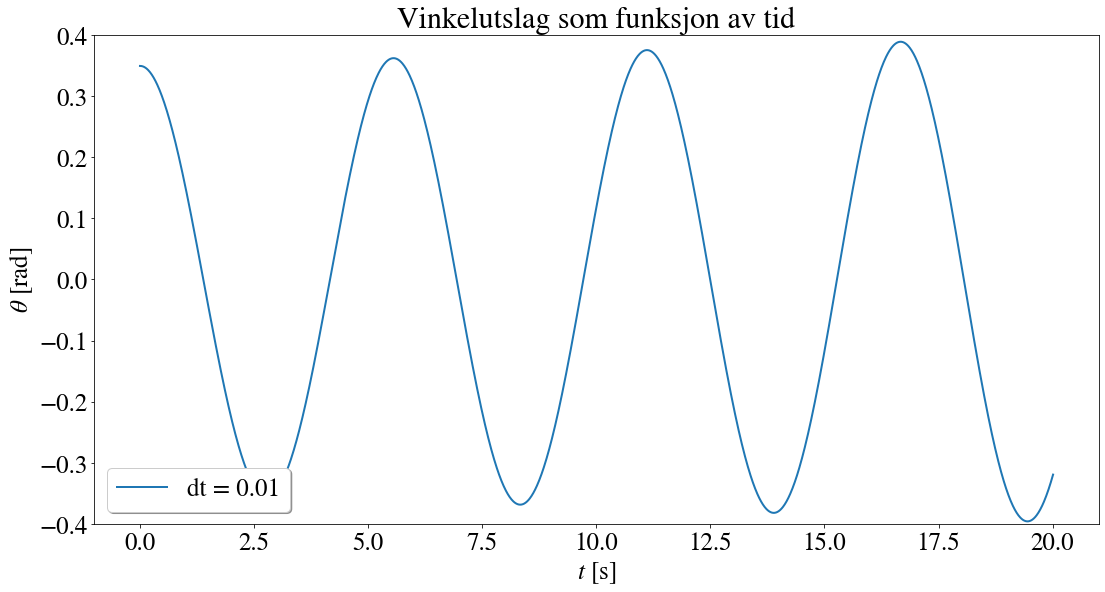

In [40]:
plt.plot(t_num, theta_num, label = "dt = 0.01")
plt.title("Vinkelutslag som funksjon av tid")
plt.xlabel('$t$ [s]')           
plt.ylabel(r'$\theta$ [rad]')   
plt.ylim(-0.4,0.4)        
plt.legend(loc=3, shadow = True)
plt.show()

## Small angle approximation
...

In [46]:
def f(t, w):
    const = (A_s*sigma * g * h)/I_c
    return np.array([w[1], -const*np.sin(w[0])])

def f_small_angle(t, w):
    const = (A_s*sigma * g * h)/I_c
    return np.array([w[1], -const*w[0]])

In [49]:
theta_0 = np.radians(10)
omega_0 = 0
w_0 = np.array([theta_0, omega_0])

t_0 = 0
t_end = 20

h_step = 0.01

t_num, w_num = euler_method(f, t_0, t_end, w_0, h_step)
t_num_small_angle_approx, w_num_small_angle_approx = euler_method(f_small_angle, t_0, t_end, w_0, h_step)

theta_num = w_num[:,0]
omega_num = w_num[:,1]
theta_num_small_angle_approx = w_num_small_angle_approx[:,0]
omega_num_small_angle_approx = w_num_small_angle_approx[:,1]

diff = theta_num_small_angle_approx - theta_num

In [3]:
plt.plot(t_num, theta_num, label = "Ikke småvinkeapproksimasjon")
plt.plot(t_num_small_angle_approx, theta_num_small_angle_approx, label = "Småvinkeapproksimasjon")
#plt.plot(t_num, diff, label = "Differanse")
plt.title("Vinkelutslag som funksjon av tid")
plt.xlabel('$t$ [s]')           
plt.ylabel(r'$\theta$ [rad]')   
plt.ylim(-0.2,0.2)        
plt.legend(loc=3, shadow = True)
plt.show()

NameError: name 't_num' is not defined

## 1.3 Runge Kutta metoden

Implementerer fjerde ordens Runge Kutta.


In [19]:
def rk4_step(f, t, w, h):
    '''
    Tar inn en vektor-funksjon på formen f(t, _w_) = _y'_ = _y_ + _g(x)_, med nåværende tid (t) og 
    tilstand (w), og regner ut ett Runge Kutta steg.
    Inn:
        f: s-array, som beskriver et system av førsteordens diff-ligninger.
        t: float, nåvernde tid
        w: s-array, som beskriver systemet
    Ut:
        t_new: neste tidssteg (t+h)
        w_new: systemet etter ett beregnet tidssteg    
    '''
    k_1 = f(t, w)
    k_2 = f(t + 0.5*h, w + h*k_1*0.5)
    k_3 = f(t + 0.5*h, w + h*k_2*0.5)
    k_4 = f(t + 1.0*h, w + h*k_3)

    w_new = w + h*(1/6) * (k_1 + 2*k_2 + 2*k_3 + k_4)
    t_new = t + h

    return t_new, w_new




# X.0 Conclusion

Lorem Ipsum...